In [1]:
!pip install ptflops
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.6.9-py3-none-any.whl size=11712 sha256=f648b1f4e1604dbb7407f6c832d39776434826d3b0081e3964adbbeb3992d543
  Stored in directory: /root/.cache/pip/wheels/86/07/9f/879035d99d7b639bbc564d23fed862a679aee7d1a2dced8c2e
Successfully built ptflops
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 4.1 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import time
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn.functional as F
import gc
from ptflops import get_model_complexity_info
from torchmetrics.classification import MulticlassConfusionMatrix

# Problem 1

In [3]:
data_path = '../data-unversioned/ecgr4106/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(64, 64))]))
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(64, 64))]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data-unversioned/ecgr4106/cifar-10-python.tar.gz to ../data-unversioned/ecgr4106/
Files already downloaded and verified


In [4]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i+1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader, update_freq):
    train_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    main_tic = time.perf_counter()
    
    for epoch in range(1, n_epochs + 1):
        tic = time.perf_counter()
        loss_train = 0.0
        correct_train = 0
        correct_val = 0
        model_argmax = []
        labels_argmax = []
        
        for imgs, lbls in train_loader:
            images = imgs.to(device=try_gpu())
            labels = lbls.to(device=try_gpu())
            outputs = model(images)
            del images
            loss = loss_fn(outputs, labels)
            del labels
            del outputs
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            gc.collect()
            torch.cuda.empty_cache()
            
        toc = time.perf_counter()
   
        with torch.no_grad():
            total = 0
            for imgs, lbls in train_loader:
                images = imgs.to(device=try_gpu())
                labels = lbls.to(device=try_gpu())
                outputs = model(images)
                del images
                _, predicted = torch.max(outputs, dim=1)
                del outputs
                total += labels.shape[0]
                correct_train += int((predicted == labels).sum())
                del labels
                del predicted
            train_acc = round(correct_train/total, 3)
            total = 0
            for imgs, lbls in val_loader:
                images = imgs.to(device=try_gpu())
                labels = lbls.to(device=try_gpu())
                outputs = model(images)
                del images
                _, predicted = torch.max(outputs, dim=1)
                del outputs
                if epoch == 1 or epoch == n_epochs or epoch % update_freq == 0:
                    model_argmax = model_argmax + predicted.tolist()
                    labels_argmax = labels_argmax + labels.tolist()
                total += labels.shape[0]
                correct_val += int((predicted == labels).sum())
                del labels
                del predicted
            val_acc = round(correct_val/total, 3)

        train_loss_hist.append(round(loss_train / len(train_loader), 5))
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)
        label_set = set(labels_argmax)
        
        if epoch == 1 or epoch == n_epochs or epoch % update_freq == 0:
            print(f"Epoch {epoch}:\n\tDuration = {round(toc - tic, 3)} seconds\n\tTraining Loss: {train_loss_hist[-1]}\n\tTraining Accuracy: {train_acc_hist[-1]}\n\tValidation Accuracy: {val_acc_hist[-1]}")
            metric = MulticlassConfusionMatrix(num_classes=len(label_set))
            print(metric(torch.ByteTensor(model_argmax), torch.ByteTensor(labels_argmax)))
            
    main_toc = time.perf_counter()
    print(f"\nTotal Training Time = {round(main_toc - main_tic, 3)} seconds\nAverage Training Time per Epoch (including validation) = {round((main_toc - main_tic) / n_epochs , 3)} seconds")
    return train_loss_hist, train_acc_hist, val_acc_hist

def plot_model(title, loss_hist, train_hist, test_hist, leg_loc):
    fig, ax1 = plt.subplots()
    x = range(1, len(loss_hist)+1)
    ax1.plot(x, loss_hist, color='k')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Error')
    ax1.tick_params(axis='y')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy')    
    ax2.plot(x, train_hist)
    ax2.plot(x, test_hist)
    ax2.set_ylim([0, 1])
    ax1.tick_params(axis='y')
    
    fig.legend(["Training Loss", "Training Accuracy", "Testing Accuracy"], loc=leg_loc, bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
    plt.title(title)

def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.LazyBatchNorm2d())
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [5]:
train_loader_1 = DataLoader(cifar10, batch_size=64, shuffle=True)
val_loader_1 = DataLoader(cifar10_val, batch_size=64, shuffle=False)

In [6]:
class tinyVGG(nn.Module):
    def __init__(self, arch, num_classes=10):
        super(tinyVGG, self).__init__()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.conv_blks = nn.Sequential(*conv_blks, nn.Flatten())
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(64)
        self.fc3 = nn.LazyLinear(num_classes)
        self.fc_drop = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.conv_blks(x)
        out = self.fc_drop(self.relu(self.fc1(out)))
        out = self.fc_drop(self.relu(self.fc2(out)))
        out = self.fc3(out)
        return out
    
model_0 = tinyVGG(arch=((1, 64), (1, 128))).to(device=try_gpu())
optimizer_0 = optim.SGD(model_0.parameters(), lr=0.08)
model_0.eval()

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tinyVGG(
  (conv_blks): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): LazyLinear(in_features=0, out_features=128, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=64, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=10, bias=True)
  (fc_drop): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

Epoch 1:
	Duration = 62.585 seconds
	Training Loss: 2.07869
	Training Accuracy: 0.324
	Validation Accuracy: 0.33
tensor([[699,  94,   0,  33,   7,   7,  30,  26,   0, 104],
        [139, 536,   1,  49,   6,  11,  57,  14,   0, 187],
        [243, 122,  21, 135,  98,  38, 242,  55,   0,  46],
        [123, 109,   3, 318,  31,  89, 183,  38,   0, 106],
        [118,  65,   7, 133, 200,  21, 339,  70,   0,  47],
        [128,  88,   6, 251,  47, 236, 148,  33,   0,  63],
        [ 33,  78,   2, 159,  56,  24, 553,  13,   0,  82],
        [132, 117,   1, 118, 109,  30,  82, 236,   0, 175],
        [574, 160,   2,  54,   0,  24,   5,  11,   1, 169],
        [153, 232,   0,  35,   3,  11,  43,  27,   0, 496]])
Epoch 2:
	Duration = 55.115 seconds
	Training Loss: 1.74078
	Training Accuracy: 0.444
	Validation Accuracy: 0.441
tensor([[432,  66,   8,  38,   9,   6,  20,  43, 247, 131],
        [ 15, 588,   7,  28,   2,  11,  11,  24,  70, 244],
        [131,  68, 148, 133,  97,  43, 154, 112,  70

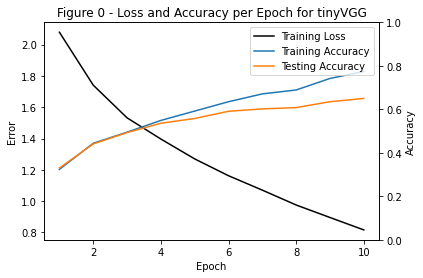

In [7]:
torch.cuda.empty_cache()
gc.collect()
t_loss_hist_0, t_acc_hist_0, v_acc_hist_0= training_loop(10,
                                                        optimizer_0,
                                                        model_0,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        1)
title_0 = "Figure 0 - Loss and Accuracy per Epoch for tinyVGG"
plot_model(title_0, t_loss_hist_0, t_acc_hist_0, v_acc_hist_0, 'upper right')

In [39]:
class VGG_11(nn.Module):
    def __init__(self, arch, num_classes=10):
        super(VGG_11, self).__init__()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.conv_blks = nn.Sequential(*conv_blks, nn.Flatten())
        self.fc1 = nn.LazyLinear(4096)
        self.fc2 = nn.LazyLinear(4096)
        self.fc3 = nn.LazyLinear(num_classes)
        self.fc_drop = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.conv_blks(x)
        out = self.fc_drop(self.relu(self.fc1(out)))
        out = self.fc_drop(self.relu(self.fc2(out)))
        out = self.fc3(out)
        return out
    
model_1 = VGG_11(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).to(device=try_gpu())
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.1)
model_1.eval()

VGG_11(
  (conv_blks): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affi

Epoch 1:
	Duration = 78.519 seconds
	Training Loss: 2.30272
	Training Accuracy: 0.1
	Validation Accuracy: 0.1
tensor([[   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0]])
Epoch 2:
	Duration = 78.586 seconds
	Training Loss: 2.30284
	Training Accuracy: 0.1
	Validation Accuracy: 0.1
tensor([[   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
        [

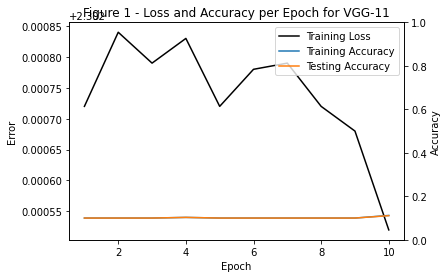

In [9]:
torch.cuda.empty_cache()
gc.collect()
t_loss_hist_1, t_acc_hist_1, v_acc_hist_1 = training_loop(10,
                                                        optimizer_1,
                                                        model_1,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        2)
title_1 = "Figure 1 - Loss and Accuracy per Epoch for VGG-11"
plot_model(title_1, t_loss_hist_1, t_acc_hist_1, v_acc_hist_1, 'upper right')

In [ ]:
class VGG_16(nn.Module):
    def __init__(self, arch, num_classes=10):
        super(VGG_16, self).__init__()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.conv_blks = nn.Sequential(*conv_blks, nn.Flatten())
        self.fc1 = nn.LazyLinear(4096)
        self.fc2 = nn.LazyLinear(4096)
        self.fc3 = nn.LazyLinear(num_classes)
        self.fc_drop = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.conv_blks(x)
        out = self.fc_drop(self.relu(self.fc1(out)))
        out = self.fc_drop(self.relu(self.fc2(out)))
        out = self.fc3(out)
        return out
    
model_2 = VGG_16(arch=((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))).to(device=try_gpu())
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.1)
model_2.eval()

In [ ]:
torch.cuda.empty_cache()
gc.collect()
t_loss_hist_2, t_acc_hist_2, v_acc_hist_2 = training_loop(3,
                                                        optimizer_2,
                                                        model_2,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        1)
title_2 = "Figure 2 - Loss and Accuracy per Epoch for VGG-16"
plot_model(title_2, t_loss_hist_2, t_acc_hist_2, v_acc_hist_2, 'upper right')

In [ ]:
class VGG_19(nn.Module):
    def __init__(self, arch, num_classes=10):
        super(VGG_19, self).__init__()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.conv_blks = nn.Sequential(*conv_blks, nn.Flatten())
        self.fc1 = nn.LazyLinear(4096)
        self.fc2 = nn.LazyLinear(4096)
        self.fc3 = nn.LazyLinear(num_classes)
        self.fc_drop = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.conv_blks(x)
        out = self.fc_drop(self.relu(self.fc1(out)))
        out = self.fc_drop(self.relu(self.fc2(out)))
        out = self.fc3(out)
        return out
    
model_3 = VGG_19(arch=((2, 64), (2, 128), (4, 256), (4, 512), (4, 512))).to(device=try_gpu())
optimizer_3 = optim.SGD(model_3.parameters(), lr=0.1)
model_3.eval()

In [ ]:
torch.cuda.empty_cache()
gc.collect()
t_loss_hist_3, t_acc_hist_3, v_acc_hist_3 = training_loop(3,
                                                        optimizer_3,
                                                        model_3,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        1)
title_3 = "Figure 3 - Loss and Accuracy per Epoch for VGG-19"
plot_model(title_3, t_loss_hist_3, t_acc_hist_3, v_acc_hist_3, 'upper right')

# Problem 2

In [10]:
class Inception(nn.Module):
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)
        
    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

In [11]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogLeNet, self).__init__()
        self.stem = nn.Sequential(nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                                 nn.LazyConv2d(64, kernel_size=1),
                                 nn.ReLU(),
                                 nn.LazyConv2d(192, kernel_size=3, padding=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.body1 = nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                                  Inception(128, (128, 192), (32, 96), 64),
                                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.body2 = nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                                  Inception(160, (112, 124), (24, 64), 64),
                                  Inception(128, (128, 256), (24, 64), 64),
                                  Inception(112, (144, 288), (32, 64), 64),
                                  Inception(256, (160, 320), (32, 128), 128),
                                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.body3 = nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                                  Inception(384, (192, 384), (48, 128), 128),
                                  nn.AdaptiveAvgPool2d((1,1)),
                                  nn.Flatten())
        self.fc = nn.LazyLinear(num_classes)
        
        
    def forward(self, x):
        out = self.stem(x)
        out = self.body1(out)
        out = self.body2(out)
        out = self.body3(out)
        out = self.fc(out)
        return out
    
model_4 = GoogLeNet().to(device=try_gpu())
optimizer_4 = optim.SGD(model_4.parameters(), lr=0.1)
model_4.eval()

GoogLeNet(
  (stem): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
    (4): ReLU()
    (5): LazyConv2d(0, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (body1): Sequential(
    (0): Inception(
      (b1_1): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
      (b2_1): LazyConv2d(0, 96, kernel_size=(1, 1), stride=(1, 1))
      (b2_2): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (b3_1): LazyConv2d(0, 16, kernel_size=(1, 1), stride=(1, 1))
      (b3_2): LazyConv2d(0, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (b4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (b4_2): LazyConv2d(0, 

Epoch 1:
	Duration = 60.74 seconds
	Training Loss: 2.30283
	Training Accuracy: 0.1
	Validation Accuracy: 0.1
tensor([[   0,    0,    0,    0,    0, 1000,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0, 1000,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0, 1000,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0, 1000,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0, 1000,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0, 1000,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0, 1000,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0, 1000,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0, 1000,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0, 1000,    0,    0,    0,    0]])
Epoch 2:
	Duration = 62.559 seconds
	Training Loss: 2.30278
	Training Accuracy: 0.1
	Validation Accuracy: 0.1
tensor([[   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
        [ 

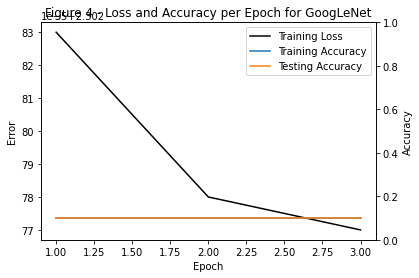

In [12]:
torch.cuda.empty_cache()
gc.collect()
t_loss_hist_4, t_acc_hist_4, v_acc_hist_4 = training_loop(3,
                                                        optimizer_4,
                                                        model_4,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        1)
title_4 = "Figure 4 - Loss and Accuracy per Epoch for GoogLeNet"
plot_model(title_4, t_loss_hist_4, t_acc_hist_4, v_acc_hist_4, 'upper right')

In [17]:
class AltGoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogLeNet, self).__init__()
        self.stem = nn.Sequential(nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3), 
                                  nn.LazyBatchNorm2d(),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                                  nn.LazyConv2d(64, kernel_size=1),
                                  nn.LazyBatchNorm2d(),
                                  nn.ReLU(),
                                  nn.LazyConv2d(192, kernel_size=3, padding=1),
                                  nn.LazyBatchNorm2d(),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.body1 = nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                                  Inception(128, (128, 192), (32, 96), 64),
                                  nn.LazyBatchNorm2d(), 
                                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.body2 = nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                                  Inception(160, (112, 124), (24, 64), 64),
                                  Inception(128, (128, 256), (24, 64), 64),
                                  Inception(112, (144, 288), (32, 64), 64),
                                  Inception(256, (160, 320), (32, 128), 128),
                                  nn.LazyBatchNorm2d(),
                                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.body3 = nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                                  Inception(384, (192, 384), (48, 128), 128),
                                  nn.LazyBatchNorm2d(),
                                  nn.AdaptiveAvgPool2d((1,1)),
                                  nn.Flatten())
        self.fc = nn.LazyLinear(num_classes)
        
        
    def forward(self, x):
        out = self.stem(x)
        out = self.body1(out)
        out = self.body2(out)
        out = self.body3(out)
        out = self.fc(out)
        return out
    
model_5 = GoogLeNet().to(device=try_gpu())
optimizer_5 = optim.SGD(model_5.parameters(), lr=0.1)
model_5.eval()

GoogLeNet(
  (stem): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
    (4): ReLU()
    (5): LazyConv2d(0, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (body1): Sequential(
    (0): Inception(
      (b1_1): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
      (b2_1): LazyConv2d(0, 96, kernel_size=(1, 1), stride=(1, 1))
      (b2_2): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (b3_1): LazyConv2d(0, 16, kernel_size=(1, 1), stride=(1, 1))
      (b3_2): LazyConv2d(0, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (b4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (b4_2): LazyConv2d(0, 

In [18]:
torch.cuda.empty_cache()
gc.collect()
t_loss_hist_5, t_acc_hist_5, v_acc_hist_5 = training_loop(10,
                                                        optimizer_5,
                                                        model_5,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        2)
title_5 = "Figure 5 - Loss and Accuracy per Epoch for GoogLeNet with Batch Norm"
plot_model(title_5, t_loss_hist_5, t_acc_hist_5, v_acc_hist_5, 'upper right')

Epoch 1:
	Duration = 59.662 seconds
	Training Loss: 2.30278
	Training Accuracy: 0.1
	Validation Accuracy: 0.1
tensor([[   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0]])
Epoch 2:
	Duration = 59.788 seconds
	Training Loss: 2.3028
	Training Accuracy: 0.1
	Validation Accuracy: 0.1
tensor([[   0,    0,    0,    0,    0,    0,    0, 1000,    0,    0],
        [ 

KeyboardInterrupt: ignored

# Problem 3

In [20]:
class Residual(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn = nn.LazyBatchNorm2d()
        
    def forward(self, x):
        y = F.relu(self.bn(self.conv1(x)))
        y = self.bn(self.conv2(y))
        if self.conv3:
            x = self.bn(self.conv3(x))    
        y += x
        return F.relu(y)

def block(num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [21]:
class ResNet(nn.Module):
    def __init__(self, arch, num_classes=10):
        super(ResNet, self).__init__()
        self.stem = nn.Sequential(nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
                              nn.LazyBatchNorm2d(), 
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        blks = []
        for i, b in enumerate(arch):
            blks.append(block(*b, first_block=(i==0)))
        self.blks = nn.Sequential(*blks)
        self.head = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                 nn.Flatten(),
                                 nn.LazyLinear(num_classes))

    def forward(self, x):
        out = self.stem(x)
        out = self.blks(out)
        out = self.head(out)
        return out

model_6 = ResNet(arch=((2, 64), (2, 128), (2, 256), (2,512))).to(device=try_gpu())
optimizer_6 = optim.SGD(model_6.parameters(), lr=0.01)
model_6.eval()

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


ResNet(
  (stem): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (blks): Sequential(
    (0): Sequential(
      (0): Residual(
        (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Residual(
        (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Sequential(
      (0): Residual(
        (

Epoch 1:
	Duration = 59.61 seconds
	Training Loss: 2.30173
	Training Accuracy: 0.149
	Validation Accuracy: 0.153
tensor([[637,   0,   0,   0, 363,   0,   0,   0,   0,   0],
        [325,   0,   0,   0, 675,   0,   0,   0,   0,   0],
        [232,   0,   0,   0, 768,   0,   0,   0,   0,   0],
        [177,   0,   0,   0, 823,   0,   0,   0,   0,   0],
        [109,   0,   0,   0, 891,   0,   0,   0,   0,   0],
        [164,   0,   0,   0, 836,   0,   0,   0,   0,   0],
        [112,   0,   0,   0, 888,   0,   0,   0,   0,   0],
        [268,   0,   0,   0, 732,   0,   0,   0,   0,   0],
        [597,   0,   0,   0, 403,   0,   0,   0,   0,   0],
        [522,   0,   0,   0, 478,   0,   0,   0,   0,   0]])
Epoch 2:
	Duration = 57.799 seconds
	Training Loss: 2.29885
	Training Accuracy: 0.126
	Validation Accuracy: 0.129
tensor([[972,   0,   0,   0,  28,   0,   0,   0,   0,   0],
        [877,   0,   0,   0, 121,   0,   0,   0,   0,   2],
        [797,   0,   0,   0, 203,   0,   0,   0,   0

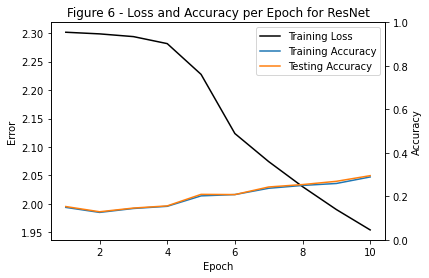

In [22]:
torch.cuda.empty_cache()
gc.collect()
t_loss_hist_6, t_acc_hist_6, v_acc_hist_6 = training_loop(10,
                                                        optimizer_6,
                                                        model_6,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        2)
title_6 = "Figure 6 - Loss and Accuracy per Epoch for ResNet"
plot_model(title_6, t_loss_hist_6, t_acc_hist_6, v_acc_hist_6, 'upper right')

In [26]:
class Residual26(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(in_channels, kernel_size=1)
        self.conv2 = nn.LazyConv2d(in_channels, kernel_size=3, padding=1)
        self.conv3 = nn.LazyConv2d(out_channels, kernel_size=1)
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(out_channels, kernel_size=1, stride=strides)
        else:
            self.conv4 = None
        self.bn = nn.LazyBatchNorm2d()
        
    def forward(self, x):
        y = F.relu(self.bn(self.conv1(x)))
        y = F.relu(self.bn(self.conv2(y)))
        y = self.bn(self.conv3(y))
        if self.conv4:
            x = self.bn(self.conv4(x))    
        y += x
        return F.relu(y)

def block26(num_residuals, in_channels, out_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual26(in_channels, out_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual26(in_channels, out_channels))
    return nn.Sequential(*blk)

In [36]:
class ResNet26(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet26, self).__init__()
        self.stem = nn.Sequential(nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
                                nn.LazyBatchNorm2d(), 
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.b1_1 = nn.Sequential(nn.LazyConv2d(64, kernel_size=1),
                                 nn.LazyBatchNorm2d(),
                                 nn.ReLU(),
                                 nn.LazyConv2d(64, kernel_size=3, padding=1),
                                 nn.LazyBatchNorm2d(),
                                 nn.ReLU(),
                                 nn.LazyConv2d(256, kernel_size=1),
                                 nn.LazyBatchNorm2d())
        self.b1_2 = nn.Sequential(nn.LazyConv2d(256, kernel_size=1),
                                 nn.LazyBatchNorm2d())
        self.b2 = nn.Sequential(nn.LazyConv2d(64, kernel_size=1),
                                 nn.LazyBatchNorm2d(),
                                 nn.ReLU(),
                                 nn.LazyConv2d(64, kernel_size=3, padding=1),
                                 nn.LazyBatchNorm2d(),
                                 nn.ReLU(),
                                 nn.LazyConv2d(256, kernel_size=1),
                                 nn.LazyBatchNorm2d())
        self.b3_1 = nn.Sequential(nn.LazyConv2d(128, kernel_size=1),
                                 nn.LazyBatchNorm2d(),
                                 nn.ReLU(),
                                 nn.LazyConv2d(128, kernel_size=3, padding=1),
                                 nn.LazyBatchNorm2d(),
                                 nn.ReLU(),
                                 nn.LazyConv2d(512, kernel_size=1),
                                 nn.LazyBatchNorm2d())
        self.b3_2 = nn.Sequential(nn.LazyConv2d(512, kernel_size=1),
                                 nn.LazyBatchNorm2d())
        self.b4 = nn.Sequential(nn.LazyConv2d(128, kernel_size=1),
                                 nn.LazyBatchNorm2d(),
                                 nn.ReLU(),
                                 nn.LazyConv2d(128, kernel_size=3, padding=1),
                                 nn.LazyBatchNorm2d(),
                                 nn.ReLU(),
                                 nn.LazyConv2d(512, kernel_size=1),
                                 nn.LazyBatchNorm2d())
        self.b5_1 = nn.Sequential(nn.LazyConv2d(256, kernel_size=1),
                                 nn.LazyBatchNorm2d(),
                                 nn.ReLU(),
                                 nn.LazyConv2d(256, kernel_size=3, padding=1),
                                 nn.LazyBatchNorm2d(),
                                 nn.ReLU(),
                                 nn.LazyConv2d(1024, kernel_size=1),
                                 nn.LazyBatchNorm2d())
        self.b5_2 = nn.Sequential(nn.LazyConv2d(1024, kernel_size=1),
                                 nn.LazyBatchNorm2d())
        self.b6 = nn.Sequential(nn.LazyConv2d(256, kernel_size=1),
                                 nn.LazyBatchNorm2d(),
                                 nn.ReLU(),
                                 nn.LazyConv2d(256, kernel_size=3, padding=1),
                                 nn.LazyBatchNorm2d(),
                                 nn.ReLU(),
                                 nn.LazyConv2d(1024, kernel_size=1),
                                 nn.LazyBatchNorm2d())
        self.b7_1 = nn.Sequential(nn.LazyConv2d(512, kernel_size=1),
                                 nn.LazyBatchNorm2d(),
                                 nn.ReLU(),
                                 nn.LazyConv2d(512, kernel_size=3, padding=1),
                                 nn.LazyBatchNorm2d(),
                                 nn.ReLU(),
                                 nn.LazyConv2d(2048, kernel_size=1),
                                 nn.LazyBatchNorm2d())
        self.b7_2 = nn.Sequential(nn.LazyConv2d(2048, kernel_size=1),
                                 nn.LazyBatchNorm2d())
        self.b8 = nn.Sequential(nn.LazyConv2d(512, kernel_size=1),
                                 nn.LazyBatchNorm2d(),
                                 nn.ReLU(),
                                 nn.LazyConv2d(512, kernel_size=3, padding=1),
                                 nn.LazyBatchNorm2d(),
                                 nn.ReLU(),
                                 nn.LazyConv2d(2048, kernel_size=1),
                                 nn.LazyBatchNorm2d())
        self.relu = nn.ReLU()
        self.head = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                 nn.Flatten(),
                                 nn.LazyLinear(num_classes))

    def forward(self, x):
        out = self.stem(x)
        out = self.relu(self.b1_1(out) + self.b1_2(out))
        out = self.relu(out + self.b2(out))
        out = self.relu(self.b3_1(out) + self.b3_2(out))
        out = self.relu(out + self.b4(out))
        out = self.relu(self.b5_1(out) + self.b5_2(out))
        out = self.relu(out + self.b6(out))
        out = self.relu(self.b7_1(out) + self.b7_2(out))
        out = self.relu(out + self.b8(out))
        out = self.head(out)
        return out

model_7 = ResNet26().to(device=try_gpu())
optimizer_7 = optim.SGD(model_7.parameters(), lr=0.1)
model_7.eval()

ResNet26(
  (stem): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (b1_1): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): LazyConv2d(0, 256, kernel_size=(1, 1), stride=(1, 1))
    (7): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (b1_2): Sequential(
    (0): LazyConv2d(0, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_

Epoch 1:
	Duration = 317.779 seconds
	Training Loss: 2.15581
	Training Accuracy: 0.194
	Validation Accuracy: 0.194
tensor([[614,  98,  62,   0,   8,   0,  38,   6, 174,   0],
        [339, 244, 177,   0,  30,   0,  77,   3, 130,   0],
        [185, 126, 147,   0,  55,   0, 384,  42,  61,   0],
        [116, 180, 264,   0,  75,   0, 264,  24,  77,   0],
        [ 84, 107, 121,   0,  39,   0, 557,  37,  55,   0],
        [ 96, 204, 260,   0,  64,   0, 270,  22,  84,   0],
        [ 47,  95, 116,   0,  53,   0, 622,  42,  25,   0],
        [102, 225, 342,   0,  58,   0, 205,  24,  44,   0],
        [559, 120,  48,   0,   8,   0,  13,   4, 248,   0],
        [390, 262, 165,   0,  17,   0,  38,   6, 122,   0]])
Epoch 3:
	Duration = 318.744 seconds
	Training Loss: 2.06923
	Training Accuracy: 0.231
	Validation Accuracy: 0.235
tensor([[300, 174,   7,   0,  21,   9,  48,  78, 239, 124],
        [ 83, 411,  10,   0,  10,  39,  56, 147, 153,  91],
        [ 78, 100,  27,   0, 107,  20, 460, 110, 

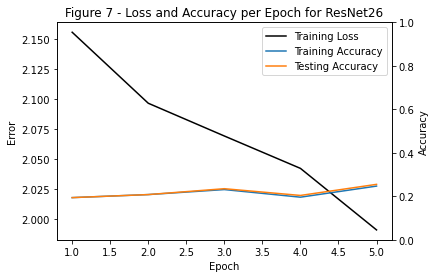

In [38]:
torch.cuda.empty_cache()
gc.collect()
t_loss_hist_7, t_acc_hist_7, v_acc_hist_7 = training_loop(5,
                                                        optimizer_7,
                                                        model_7,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        3)
title_7 = "Figure 7 - Loss and Accuracy per Epoch for ResNet26"
plot_model(title_7, t_loss_hist_7, t_acc_hist_7, v_acc_hist_7, 'upper right')

In [30]:
class ResNet34(nn.Module):
    def __init__(self, arch, num_classes=10):
        super(ResNet34, self).__init__()
        self.stem = nn.Sequential(nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
                              nn.LazyBatchNorm2d(), 
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        blks = []
        for i, b in enumerate(arch):
            blks.append(block(*b, first_block=(i==0)))
        self.blks = nn.Sequential(*blks)
        self.head = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                 nn.Flatten(),
                                 nn.LazyLinear(num_classes))

    def forward(self, x):
        out = self.stem(x)
        out = self.blks(out)
        out = self.head(out)
        return out

model_8 = ResNet34(arch=((3, 64), (4, 128), (6, 256), (3,512))).to(device=try_gpu())
optimizer_8 = optim.SGD(model_8.parameters(), lr=0.01)
model_8.eval()

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


ResNet34(
  (stem): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (blks): Sequential(
    (0): Sequential(
      (0): Residual(
        (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Residual(
        (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Residual(
        (conv1): LazyConv2d(0, 64,

Epoch 1:
	Duration = 66.322 seconds
	Training Loss: 1.85303
	Training Accuracy: 0.33
	Validation Accuracy: 0.338
tensor([[521, 122,   9,  27,   1,  23,   9,  30, 204,  54],
        [104, 512,   3,  24,   1,  31,   8,  13, 180, 124],
        [139,  82,  55, 103,  90, 185, 152, 112,  47,  35],
        [ 86,  68,  25, 260,  12, 260,  90, 108,  47,  44],
        [ 65,  35,  19, 101, 162, 163, 243, 132,  49,  31],
        [ 61,  79,  25, 178,  16, 347,  81, 116,  53,  44],
        [ 27,  57,   9, 140,  65, 199, 355, 117,  15,  16],
        [ 69,  96,  14,  94,  21, 125,  48, 360,  31, 142],
        [279, 122,   1,  39,   0,  18,   0,  16, 461,  64],
        [ 99, 185,  12,  31,   1,  29,   4,  62, 226, 351]])
Epoch 2:
	Duration = 65.853 seconds
	Training Loss: 1.81662
	Training Accuracy: 0.345
	Validation Accuracy: 0.352
tensor([[512,  79,  17,  58,  16,  26,   8,  77, 124,  83],
        [116, 435,   3,  47,   4,  35,  14,  52,  83, 211],
        [ 90,  44,  42, 150, 275, 112,  95, 161,  15

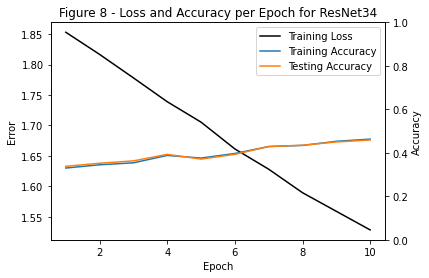

In [32]:
torch.cuda.empty_cache()
gc.collect()
t_loss_hist_8, t_acc_hist_8, v_acc_hist_8 = training_loop(10,
                                                        optimizer_8,
                                                        model_8,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        2)
title_8 = "Figure 8 - Loss and Accuracy per Epoch for ResNet34"
plot_model(title_8, t_loss_hist_8, t_acc_hist_8, v_acc_hist_8, 'upper right')